In [1]:
from dataloader import CircleDataset, CircleRaw
from DETR_model import DinoDETR
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from polygon import RasLoss, SoftPolygon
from ModelInfer import ModelInfer

In [2]:
query_embed = nn.Embedding(80, 384)
query_embed.weight.shape

torch.Size([80, 384])

In [3]:
raw_set = CircleRaw()
data_set = CircleDataset()
batch_size = 1
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True)

In [4]:
model = DinoDETR().cuda()

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main
/work3/s232248/miniconda3/envs/ras/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [5]:
(
    pre_idx,
    fir_img,
    fir_sgm,
    fir_bou,
    pre_img,
    pre_sgm,
    pre_bou,
    cur_img,
    cur_sgm,
    cur_bou,
) = next(iter(data_loader))
pre_idx

tensor([10])

In [6]:
model_infer = ModelInfer(raw_set, is_detr=True)

In [7]:
model_infer.infer_model(model)

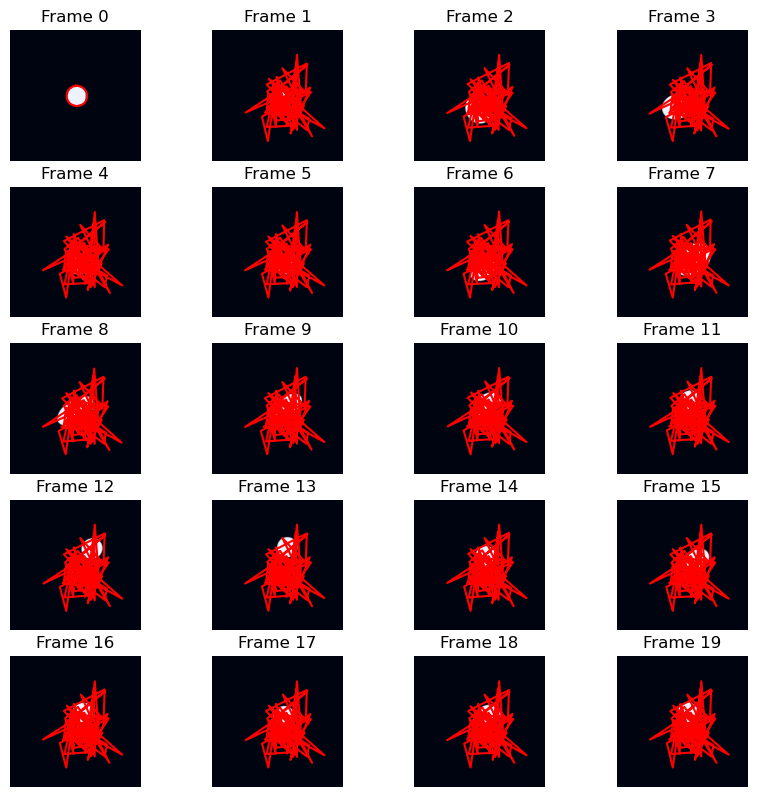

tensor(0.1916)

In [8]:
model_infer.show_infer_result(0)

In [9]:
model(
    fir_img.cuda(),
    fir_sgm.cuda(),
    pre_img.cuda(),
    pre_sgm.cuda(),
    cur_img.cuda(),
).shape

torch.Size([1, 80, 2])

In [10]:
model = DinoDETR().cuda()
ras_loss = RasLoss()
model_infer = ModelInfer(raw_set, is_detr=True)

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main


In [11]:
loss_dict = {}
iou_dict = {}
interval_epochs = 150
inter_num = 42
epoch_index = 0
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Epoch 0 Loss: 0.8153874058472482
Epoch 1 Loss: 0.8294582774764613
Epoch 2 Loss: 0.8106650145430314
Epoch 3 Loss: 0.8309826035248605
Epoch 4 Loss: 0.8364755730879935
Epoch 5 Loss: 0.8385673761367798
Epoch 6 Loss: 0.7784518411284999
Epoch 7 Loss: 0.7317419836395666
Epoch 8 Loss: 0.7865453676173562
Epoch 9 Loss: 0.7327771092716017
Epoch 10 Loss: 0.7058807203644201
Epoch 11 Loss: 0.6431250509462858
Epoch 12 Loss: 0.8523957101922286
Epoch 13 Loss: 0.7016712113430625
Epoch 14 Loss: 0.6298778715886568
Epoch 15 Loss: 0.5555980393761083
Epoch 16 Loss: 0.6623637519384685
Epoch 17 Loss: 0.635401211286846
Epoch 18 Loss: 0.664274441568475
Epoch 19 Loss: 0.750158987547222
Epoch 20 Loss: 0.6268836730404904
Epoch 21 Loss: 0.5658491818528426
Epoch 22 Loss: 0.6841550218431574
Epoch 23 Loss: 0.637563190962139
Epoch 24 Loss: 0.5024658535656176
Epoch 25 Loss: 0.49522051999443456
Epoch 26 Loss: 0.512081547787315
Epoch 27 Loss: 0.5278023732335944
Epoch 28 Loss: 0.5274180048390439
Epoch 29 Loss: 0.54869853822

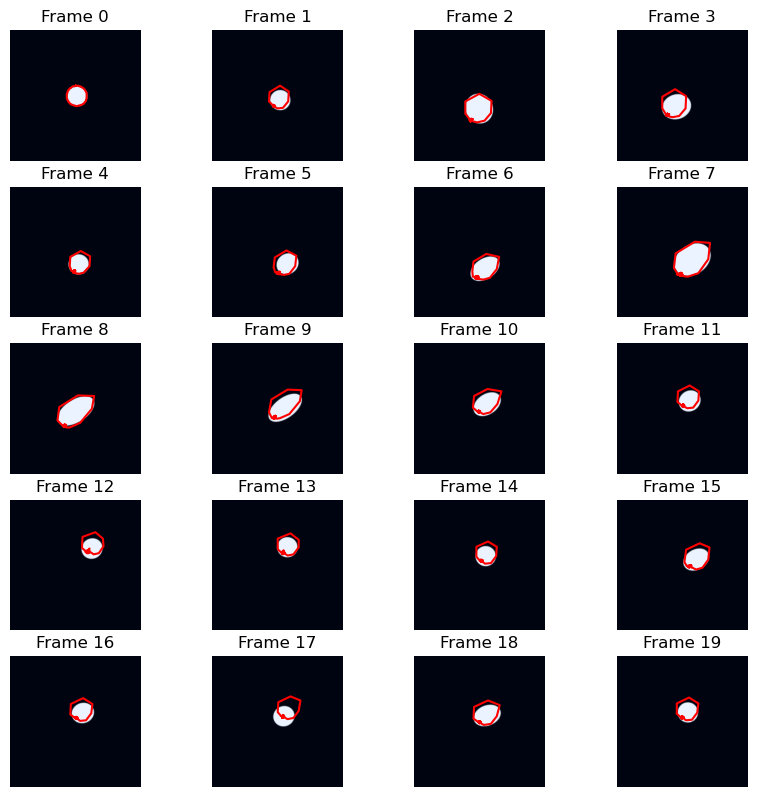

In [12]:
for interval in range(inter_num):
    for e in range(interval_epochs):
        model.train()
        mean_loss = 0
        for (
            pre_idx,
            fir_img,
            fir_sgm,
            fir_bou,
            pre_img,
            pre_sgm,
            pre_bou,
            cur_img,
            cur_sgm,
            cur_bou,
        ) in data_loader:
            pre_idx = pre_idx.item()
            pre_sgm = model_infer.get_segement(pre_idx)
            pre_sgm = pre_sgm.unsqueeze(0)
            optimizer.zero_grad()
            pred_bou = model(
                fir_img.cuda(),
                fir_sgm.cuda(),
                pre_img.cuda(),
                pre_sgm.cuda(),
                cur_img.cuda(),
            )
            loss = ras_loss(pred_bou, cur_sgm.cuda())
            loss.backward()
            optimizer.step()
            mean_loss += loss.item()
        mean_loss /= len(data_loader)
        loss_dict[epoch_index] = mean_loss
        print(f"Epoch {epoch_index} Loss: {mean_loss}")
        epoch_index += 1
    model_infer.infer_model(model)
    total_iou = model_infer.get_infer_iou(0)
    iou_dict[epoch_index] = total_iou
    print(f"Epoch {epoch_index} IOU: {total_iou}")
    model_infer.show_infer_result(0)
    break
    if interval_epochs > 50:
        interval_epochs = 50
    if interval_epochs > 20:
        interval_epochs -= 10
            
            